In [1]:
from copy import deepcopy
import datetime
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import os
import sys
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('..')
from lc_investing.backtest import Backtest

In [6]:
# run backtests
start_date = '1940-01-31'
end_date = '2023-12-31'

rebal_dates_dict = {'none': []} | {freq: pd.date_range(start_date, end_date, freq=freq).tolist() for freq in reversed(['ME', 'QE', 'YE', '2YE', '5YE', '10YE'])}
results_list = []

for leverage_value in [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]:
    print('leverage_value:', leverage_value, end=' | ')    
    b = Backtest(initial_leverage=leverage_value)
    b.get_data(data_filename="../Core_simulation.xlsx",
            start_date=start_date,
            end_date=end_date)
    b.run(rebalance_dates=[])
    stats = deepcopy(b.stats)
    stats.insert(loc=0, column='freq', value='none')
    results_list.append(stats)

for freq, rebal_dates in rebal_dates_dict.items():
    print('freq:', freq, end=' | ')    
    b = Backtest(initial_leverage=2.0)
    b.get_data(data_filename="../Core_simulation.xlsx",
               start_date=start_date,
               end_date=end_date)
    b.run(rebalance_dates=rebal_dates)
    stats = deepcopy(b.stats)
    stats.insert(loc=0, column='freq', value=freq)
    results_list.append(stats)


leverage_value: 1.0 | leverage_value: 1.2 | leverage_value: 1.4 | leverage_value: 1.6 | leverage_value: 1.8 | leverage_value: 2.0 | freq: none | freq: 10YE | freq: 5YE | freq: 2YE | freq: YE | freq: QE | freq: ME | 

In [8]:
summary = pd.concat(results_list, axis=0).drop(columns=['equity_compound_return_per_annum', 'levered_equity_compound_return_per_annum'])
summary

,freq,leverage,arithmetic_return_per_annum,compound_return_per_annum,volatility_per_annum,end_value_of_$1,max_drawdown
0,none,1.0,0.067931,0.061631,0.125410,63.531868,-0.516740
0,none,1.2,0.071122,0.064332,0.130251,75.790334,-0.518780
0,none,1.4,0.073965,0.066634,0.135150,88.048800,-0.520244
0,none,1.6,0.076589,0.068638,0.140307,100.307266,-0.521345
0,none,1.8,0.079093,0.070415,0.145907,112.565732,-0.522205
0,none,2.0,0.081558,0.072010,0.152145,124.824198,-0.522894
0,none,2.0,0.081558,0.072010,0.152145,124.824198,-0.522894
0,10YE,2.0,0.119250,0.063586,0.562695,72.190297,-1.090682
0,5YE,2.0,0.137122,0.083513,0.367270,261.867934,-0.951459
0,2YE,2.0,0.120844,0.061366,0.362233,62.440733,-0.946978


* Adding leverage from 1 to 2 increases the return and volatility, leaving the Sharpe ratio mostly unchanged. The astounding thing to realize is how much this extra returns increase the final portfolio value - 2x for 2x leverage. If you can live with the higher volatility, it seems definitely worth it.
* One you start reseting the leverage, I think these results depend on too few data points to be reliable. Reseting the leverage every 10 years leaves you susceptible to only several specific year's returns. I think I need to run backtest over more historical windows.
* The monthly reseting is probably the most reliable of the reseting strategies because it's not as susceptible to particular month's returns.
* Reseting the leverage drastically increases the drawdowns, which is much scarier than volatility.
* The unlevered drawdown is much smaller than in The Missing Billionaires book, probably because they have daily data and my monthly data hides large swings within months.

Differences between the Table 23.1 in "The Missing Billionaires" (TMB) and this notebook:
* For equity returns, TMB uses S&P 500 total returns while I use S&P 500 price only (excludes dividends)
* For data frequency, TMB has daily data and rebalances daily while I have monthly data
* For the borrowing rate, TMB use 3-month T-Bills plus 1% while I use historical margin rates from Nalebuff and Ayres' "Lifecycle Investing"

<Axes: xlabel='date', ylabel='leverage_with_resets'>

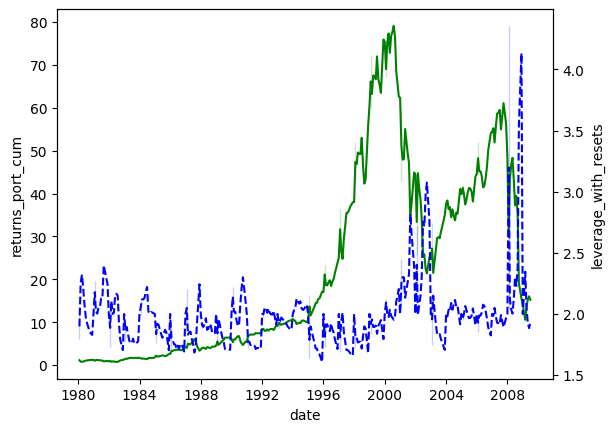

In [133]:
data2 = data1.set_index('date')
sns.lineplot(data=data2.returns_port_cum, color="g")
ax2 = plt.twinx()
sns.lineplot(data=data2.leverage_with_resets, color="b", ax=ax2, linestyle='--')

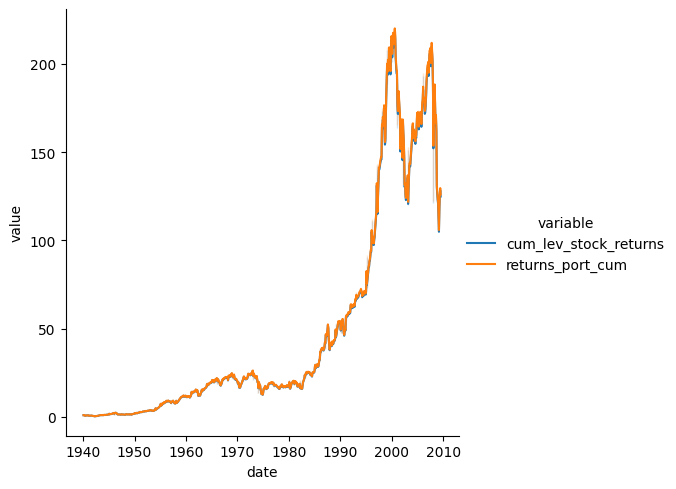

In [107]:
# Does my backtest work? The portfolio's cumulative returns should match a simple 2x stock returns calculation. It mostly does.
# 2x leverage return of stocks over this period (1 + r)
cum_ret = pd.DataFrame({'date': data1['date'],
                        'cum_lev_stock_returns': 1 + 2 * (data1['Monthly real stock rate'].cumprod().values -1),
                        'returns_port_cum': data1['returns_port_cum'].values}).melt(['date'])
sns.relplot(x = "date",
            y = "value", 
            hue='variable',
            kind = "line",
            data = cum_ret);